In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time

from torch.utils.data import DataLoader

import torch
import torch.nn as nn

%matplotlib inline

torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

gpu = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
src_domain = 'Thebe'
tgt_domain = 'Thebe'
da_method = None

# data
red = 1 # reduction factor
n_imgs = 0  # {3200, 6400} max: 12724
bs = 32 # batch size
type_aug = "type1" # type0, type1
nw = 4 # num_workers

# solo para Thebe
ps = '256to128' # patch size
step = 3 # step size

# model
net = "dexi"
f = 16 # filters on first layer

# training
optimizer = 'Adam'
lr = 1e-4
lr_adjust = False
epochs = 5
loss = 'bdcn'

# -----------------------------------------------------------------------------
config_keys = [k for k,v in globals().items() if not k.startswith('_') and isinstance(v, (int, float, bool, str))]
config = {k: globals()[k] for k in config_keys} # will be useful for logging

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = 'Thebe'

DATAPATH_SRC = os.path.join(DATAFOLDER, dataset, 'Patches2D', 'src_ps{}_step{}'.format(ps, step) )
# DATAPATH_TGT = os.path.join(DATAFOLDER, dataset, 'Patches2D', 'tgt_ps{}_step{}'.format(ps, step) )

## Load Data

In [4]:
from dataloaders import ThebeGenerator

In [5]:
train_gen = ThebeGenerator(DATAPATH_SRC, "train", red=red, n_imgs=n_imgs, aug=type_aug)
val_gen = ThebeGenerator(DATAPATH_SRC, "val", red=red, n_imgs=n_imgs)

train_loader = DataLoader(dataset=train_gen, batch_size=bs, shuffle=True, drop_last=True, num_workers=nw)
val_loader = DataLoader(dataset=val_gen, batch_size=bs, shuffle=False, drop_last=True, num_workers=nw)

In [6]:
for idx, (x,y) in enumerate(val_loader):
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


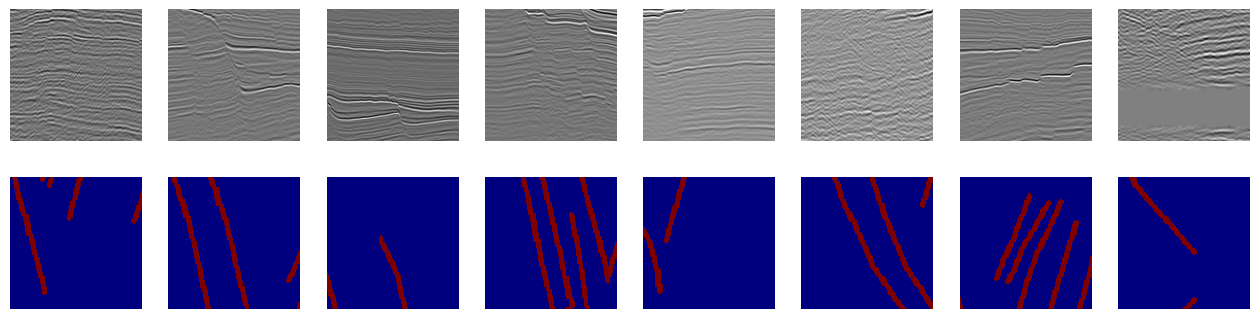

In [7]:
fig, axes = plt.subplots(2, 8, figsize=[16,4])
for i in range(8):
    ix = np.random.choice(bs)
    axes[0, i].imshow(x[ix, 0], cmap="gray")
    axes[1, i].imshow(y[ix], cmap="jet", interpolation="nearest")
    axes[0, i].axis('off')
    axes[1, i].axis('off')

## Modeling

In [8]:
from models.dexined import DexiNed
from loss import bdcn_loss2

In [9]:
model = DexiNed(f1=f).to(device)
# summary(model, (1, ps, ps))

In [10]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
# criterion = nn.BCELoss()
criterion = bdcn_loss2

## Training

In [12]:
from metrics import *

In [13]:
# saved_name = wandb.run.id
# saved_path = os.path.join(PATH, 'res', '{}.pt'.format(saved_name))
# wandb.config.update({"saved_path": saved_name})

saved_path = "delete.pt"

stopPatience = 10
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.1, patience=stopPatience//2, verbose=True)
saved_path

'delete.pt'

In [14]:
def process(dataloader, model, phase='train', opt=None):

    task_loss_ = 0.0
    iou_ = 0.0
    
    if phase=='train':
        model.train()  
    else:
        model.eval()
        
    len_data = len(dataloader)
    
    for data, labels in dataloader:

        data = data.float().to(device=device)
        labels = labels.long().to(device=device).unsqueeze(1)
        
        task_outs = model(data)
        probs = (task_outs[-1] + task_outs[2] + task_outs[3])/3.
    
        task_loss = criterion(task_outs[-1], labels, 0.5) + criterion(task_outs[2], labels, 0.5) # bdcn_loss
#         task_loss = criterion(task_outs[-1], labels, 0.33) + criterion(task_outs[2], labels, 0.33) + criterion(task_outs[3], labels, 0.33)
        task_loss = task_loss / 5 # just to keep in a similar range than BCE
    
        if phase=='train':
            # calculate the gradients
            opt.zero_grad()
            task_loss.backward()

            # update weigths
            opt.step()
        
        ## compute loss
        task_loss_ += task_loss.item()
        
        ## compute metrics
        task_output = torch.nn.Sigmoid()(probs)
        pred_ = torch.where(task_output >= 0.5, torch.ones_like(task_output), torch.zeros_like(task_output))
        iou_ += compute_iou(pred_.squeeze(1), labels.squeeze(1))

    task_loss_ = task_loss_/len_data
    iou_ = iou_/len_data
    
    if phase=='val':
        scheduler.step(task_loss)
        
    return task_loss_, iou_

In [15]:
min_valid_loss = np.inf
max_valid_vl = -np.inf
n_patience = 0
t_start = time.time()
t_start_epoch = time.time()

for ep in range(epochs):
    
    loss_tr, iou_tr = process(train_loader, model, phase='train', opt=opt)

    with torch.no_grad():
        loss_vl, iou_vl = process(val_loader, model, phase='val')
        
    t_ = time.time()-t_start_epoch
    
    # wandb.log({
    #     "train/epoch/task_loss": loss_tr,
    #     "train/epoch/iou": iou_tr,
        
    #     "val/epoch/task_loss": loss_vl,
    #     "val/epoch/iou": iou_vl,
        
    #     "train/epoch/time": t_,
    #     "train/epoch/step": ep+1
    # })    
    
    
    print('Epoch {}:   {:.1f}s - loss: {:.4f} - iou: {:.4f} - val_loss: {:.4f} - val_iou: {:.4f}'
          .format(ep+1, t_, loss_tr, iou_tr, loss_vl, iou_vl))
    
    if min_valid_loss > loss_vl:
        print(f'val_loss improved from {(min_valid_loss):.6f} to {(loss_vl):.6f} , saving model\n')
        min_valid_loss = loss_vl
        torch.save(model.state_dict(), saved_path)
        n_patience=0
    else:
        print(f'val_loss did not improve from {(min_valid_loss):.6f}\n')
        n_patience+=1
        if n_patience==stopPatience:
            print('Epoch {}:   early stopping'.format(ep+1))
            break
            
    t_start_epoch = time.time()
    
t_total = time.time()-t_start

Epoch 1:   71.1s - loss: 0.4891 - iou: 0.1323 - val_loss: 0.4765 - val_iou: 0.2826
val_loss improved from inf to 0.476528 , saving model

Epoch 2:   68.8s - loss: 0.4049 - iou: 0.2562 - val_loss: 0.4132 - val_iou: 0.3519
val_loss improved from 0.476528 to 0.413163 , saving model

Epoch 3:   72.6s - loss: 0.3678 - iou: 0.3001 - val_loss: 0.3880 - val_iou: 0.3764
val_loss improved from 0.413163 to 0.387981 , saving model

Epoch 4:   70.2s - loss: 0.3479 - iou: 0.3279 - val_loss: 0.3718 - val_iou: 0.3997
val_loss improved from 0.387981 to 0.371762 , saving model

Epoch 5:   70.8s - loss: 0.3360 - iou: 0.3450 - val_loss: 0.3714 - val_iou: 0.4194
val_loss improved from 0.371762 to 0.371379 , saving model



In [16]:
t_total/60, ep

(5.896687877178192, 4)

## Validation

In [17]:
model.load_state_dict(torch.load(saved_path))
model.eval()
print()

In [18]:
ypps = model(x.float().to(device)) #.cpu().detach().numpy()
ypp = (ypps[-1] + ypps[2] + ypps[3])/3.
ypp = torch.nn.Sigmoid()(ypp).cpu().detach().numpy()
yp = np.where(ypp[:,0] >= 0.5, 1, 0)
ypp.shape, yp.shape

((32, 1, 128, 128), (32, 128, 128))

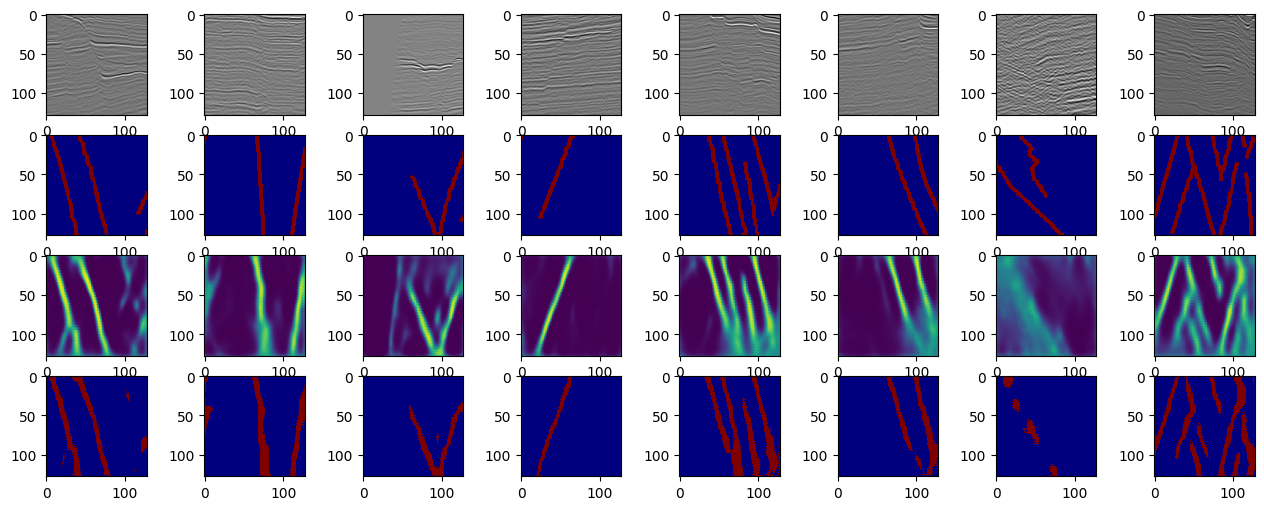

In [20]:
fig, axes = plt.subplots(4, 8, figsize=[16,6])

for i in range(8):
    axes[0, i].imshow(x[i,0], cmap="gray")
    axes[1, i].imshow(y[i], cmap="jet", interpolation="nearest")
    axes[2, i].imshow(ypp[i,0], vmin=0, vmax=1)
    axes[3, i].imshow(yp[i], cmap="jet", interpolation="nearest")
    
# wandb.log({"valid/imgs_tgt": fig})

### Metrics

In [21]:
# from torchmetrics import AveragePrecision, AUROC
import pandas as pd
from tqdm import tqdm

In [22]:
y_true_list = []
y_prob_list = []
for x, y in tqdm(val_loader):
    y = y.cpu().detach().numpy()
    y_probs = model(x.float().to(device))
    y_prob = (y_probs[-1] + y_probs[2] + y_probs[3])/3.
    y_prob = torch.nn.Sigmoid()(y_prob).cpu().detach().numpy() # probs
    
    y_true_list.append(y)
    y_prob_list.append(y_prob[:,0])
    
y_true_total = np.vstack(y_true_list)  #.ravel()
y_prob_total = np.vstack(y_prob_list) #.ravel()
y_pred_total = np.where(y_prob_total >= 0.5, 1, 0)

y_true_total.shape

100%|████████████████████████████████████████████████████████████████████████████████| 136/136 [00:10<00:00, 13.33it/s]


(4352, 128, 128)

In [23]:
th_range = np.arange(0, 1, 0.02)
metrics_list = []

y_true = torch.tensor(y_true_total, dtype=torch.float32).to(device)
y_prob = torch.tensor(y_prob_total, dtype=torch.float32).to(device)

for th in th_range:
    pr, re, f1 = binary_classification_metrics(y_prob, y_true, th)
    metrics_list.append([pr, re, f1])

In [24]:
df = pd.DataFrame(np.array(metrics_list)).reset_index(drop=True)
df.columns = ['precision', 'recall', 'f1_score']
df.index = th_range

In [25]:
f1_ = df.loc[0.5]['f1_score']
# wandb.log({"valid/f1_tgt": f1_})

In [26]:
iou = compute_iou((y_prob > 0.5).float(), y_true.contiguous())
# wandb.log({"valid/iou_tgt": iou})

In [27]:
print("Original:  IoU: {:.4f}   F1-score: {:.4f}".format(iou, f1_))

Original:  IoU: 0.4190   F1-score: 0.5905


### New Metrics

In [28]:
getNewMetrics(y_true_total, y_pred_total, sigma=1)

4352it [00:04, 902.38it/s]

With Sigma=1:  IoU: 0.5187   F1-score: 0.6596


In [29]:
getNewMetrics(y_true_total, y_pred_total, sigma=4)

4352it [00:03, 1201.81it/s]

With Sigma=4:  IoU: 0.7170   F1-score: 0.8153


In [30]:
getNewMetrics(y_true_total, y_pred_total, sigma=7)

4352it [00:03, 1207.17it/s]

With Sigma=7:  IoU: 0.7848   F1-score: 0.8643
